# Part 1 - Login EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


# Summary

* In general, we seeing an increased login trend from January to March
* We are starting to see a decline in logins starting the last week of March
* Daily login patterns are roughly the same across the 3 months
    * Busiest times are 10pm to 5am, then 11am to 1pm
    * Lowest times are from 5am to 11am in the morning
* Weekly login pattern is also roungly the same across months:
    * Monday has the lowest number of logins
    * Number of logins increases as the week goes on - with Saturday being the busiest for January and February, but in March the busiest day of login was actually Sundays

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(font_scale=2)

## Loading the Data file

* login.json is a json file with one line and with 1 column - login_time
* login_time needs to be converted into datetime format so we can do our EDA later

In [2]:
logins = pd.read_json('logins.json', convert_dates="login_time")
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


## Data range for our data

Our dataset has a around 4.5 months of data 

* First login is on 1/1 around 8 pm
* Last login data is on 4/13 around 7pm

In [3]:
logins.login_time.min()

Timestamp('1970-01-01 20:12:16')

In [4]:
logins.login_time.max()

Timestamp('1970-04-13 18:57:38')

## Do we have the same number of logins by interval?

We want to aggregate logins in 15 minute intervals. Let's first look 2 different 15 minute intervals

We can see that number of logins for 15 minute intervals are different so we can't use the rolling function for pandas since that has to be a fixed window so have to use other methods to do this.

In [5]:
logins[(logins.login_time >= '1970-01-02 00:00:00') & (logins.login_time < '1970-01-02 00:15:00')].count()

login_time    10
dtype: int64

In [6]:
logins[(logins.login_time >= '1970-01-02 00:15:00') & (logins.login_time < '1970-01-02 00:30:00')].count()

login_time    18
dtype: int64

# Preparing our Data

To aggregate, we have to group our logins by date, hour, and 15 minute intervals in our data.

First we will extract these into columns in our dataset

In [7]:
logins_clean = pd.DataFrame()
logins_clean["date"] = logins.login_time.dt.date
logins_clean["hour"] = logins.login_time.dt.hour
logins_clean["minute"] = logins.login_time.dt.minute
logins_clean["dayofweek"] = logins.login_time.dt.dayofweek

logins_clean["day"] = logins.login_time.dt.day
logins_clean["month"] = logins.login_time.dt.month

logins_clean["15_minute_interval"] = divmod(logins_clean.minute, 15)[0]
logins_clean["hour+15_minute_interval"] = logins_clean["hour"].astype(str) + "-" + logins_clean["15_minute_interval"].astype(str)
# use this column for groupby so it's easier
logins_clean["total"] = 1
logins_clean.head()

,date,hour,minute,dayofweek,day,month,15_minute_interval,hour+15_minute_interval,total
0,1970-01-01,20,13,3,1,1,0,20-0,1
1,1970-01-01,20,16,3,1,1,1,20-1,1
2,1970-01-01,20,16,3,1,1,1,20-1,1
3,1970-01-01,20,16,3,1,1,1,20-1,1
4,1970-01-01,20,26,3,1,1,1,20-1,1


In [8]:
logins_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   date                     93142 non-null  object
 1   hour                     93142 non-null  int64 
 2   minute                   93142 non-null  int64 
 3   dayofweek                93142 non-null  int64 
 4   day                      93142 non-null  int64 
 5   month                    93142 non-null  int64 
 6   15_minute_interval       93142 non-null  int64 
 7   hour+15_minute_interval  93142 non-null  object
 8   total                    93142 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 6.4+ MB


Now we group by our date, hour, and interval fields to get number of logins per 15 minute interval

In [9]:
logins_grouped = logins_clean.groupby(["date", "hour", "15_minute_interval"]).count().rename({"minute": "logins"}, axis=1)
logins_grouped

logins  dayofweek  day  month  \
date       hour 15_minute_interval                                  
1970-01-01 20   0                        2          2    2      2   
                1                        6          6    6      6   
                2                        9          9    9      9   
                3                        7          7    7      7   
           21   0                        1          1    1      1   
...                                    ...        ...  ...    ...   
1970-04-13 17   3                        5          5    5      5   
           18   0                        5          5    5      5   
                1                        2          2    2      2   
                2                        7          7    7      7   
                3                        6          6    6      6   

                                    hour+15_minute_interval  total  
date       hour 15_minute_interval                                  
1970-01-01 20   0                                         2      2  
                1                                         6      6  
                2                                         9      9  
                3                                         7      7  
           21   0                                         1      1  
...                                                     ...    ...  
1970-04-13 17   3                                         5      5  
           18   0                                         5      5  
                1                                         2      2  
                2                                         7      7  
                3                                         6      6  

[9381 rows x 6 columns]

# Logins by Month

In general, we see an increased number of total logins per month from January to March

NOTE: We only have 13 days in April for our data, so unclear on how we are doing yet

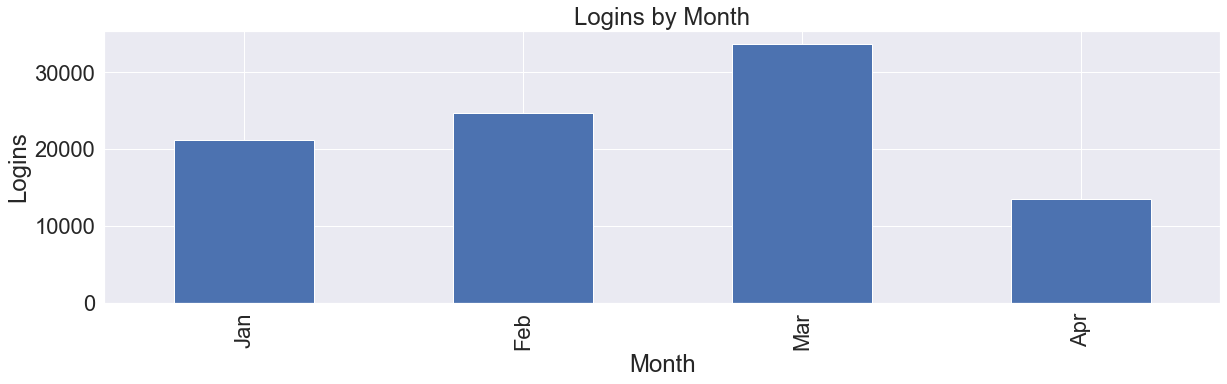

In [10]:
logins_month = logins_clean[["month", "total"]].groupby("month").count()


f, a = plt.subplots(1, 1, figsize=(20,5))

logins_month.plot(kind="bar", ax=a, legend=False)
_ = plt.xlabel("Month")
_ = plt.ylabel("Logins")
_ = plt.title("Logins by Month")
_ = a.set_xticklabels(["Jan", "Feb", "Mar", "Apr"])



# Overall Login Totals

In general, we are seeing logins increasing. However, starting in April, we are starting to see a decline in logins

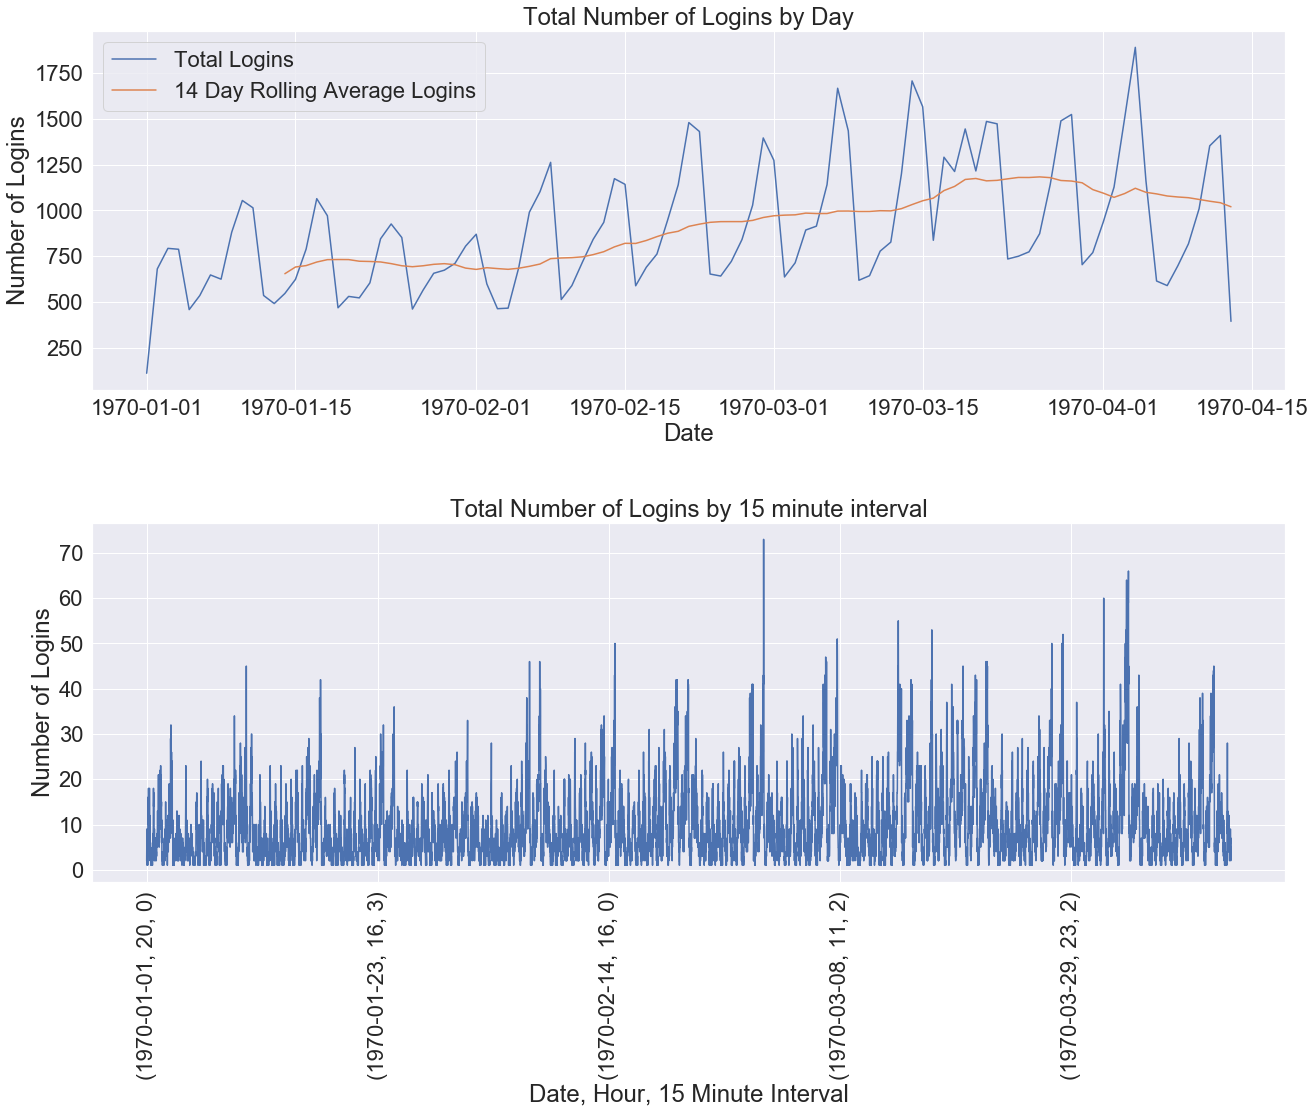

In [11]:
# calculate rolling average for logins (5 day)
logins_date = logins_clean[["date", "total"]].groupby("date").count()
logins_date["rolling_avg14"] = logins_date.rolling(window=14).mean()
logins_date = logins_date.reset_index()


f, a = plt.subplots(2, 1, figsize=(20, 15))

f.tight_layout(pad=4.0)

_ = logins_grouped["logins"].plot(kind="line", ax=a[1], legend=False)
_ = a[1].set_title("Total Number of Logins by 15 minute interval")
_ = a[1].set_xlabel("Date, Hour, 15 Minute Interval")
_ = a[1].set_ylabel("Number of Logins")
_ = plt.xticks(rotation=90)


# _ = logins_clean[["date", "total"]].groupby("date").count().plot(kind="line", ax=a[1])
_ = sns.lineplot(logins_date.date, logins_date.total, ax=a[0], label="Total Logins")
_ = sns.lineplot(logins_date.date, logins_date.rolling_avg14, ax=a[0], label="14 Day Rolling Average Logins")
_ = a[0].set_title("Total Number of Logins by Day")
_ = a[0].set_xlabel("Date")
_ = a[0].set_ylabel("Number of Logins")
_ = plt.xticks(rotation=90)




# Login by Week

In this graph, you can see more specifically that starting the last week of March, we are seeing a decling in total number of logins

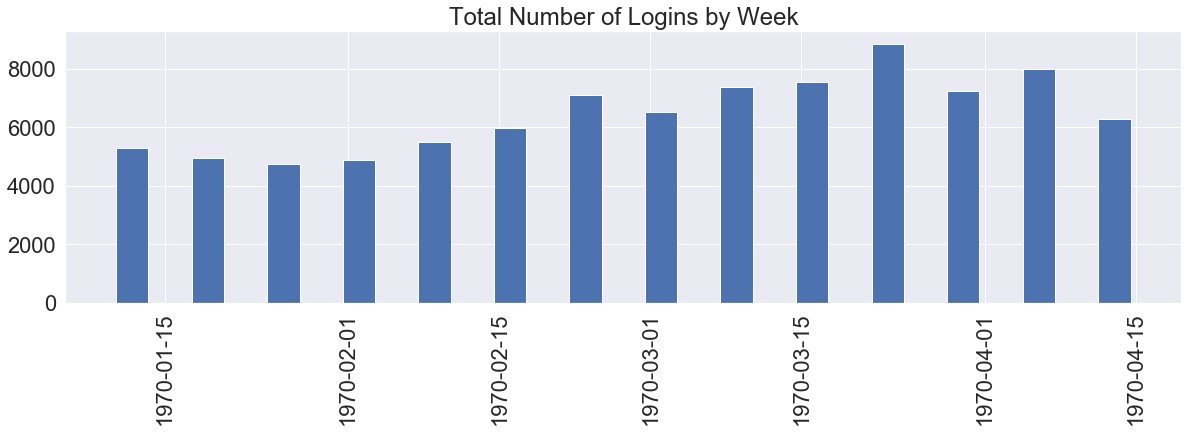

In [48]:
logins_date = logins_clean[["date", "total", "dayofweek"]].groupby(["date", "dayofweek"]).count()
logins_date["rolling_sum7"] = logins_date.rolling(window=7).sum()
logins_date = logins_date.reset_index()

logins_by_week = logins_date[logins_date.dayofweek == 0][["date", "rolling_sum7"]]


f, a = plt.subplots(1, 1, figsize=(20, 5))
plt.bar(logins_by_week.date, logins_by_week.rolling_sum7, width=3)
plt.xticks(rotation=90)
_ = plt.title("Total Number of Logins by Week")

# Hourly Login Behavior

Daily login patterns are roughly the same when you look at them by month with February and March having larger numbers - only exception is 4pm and 5pm where January had more logins during those hours than Februry

Busiest times are 10pm to 5am, then 11am to 1pm

Slowest times are from 5am to 11am in the morning


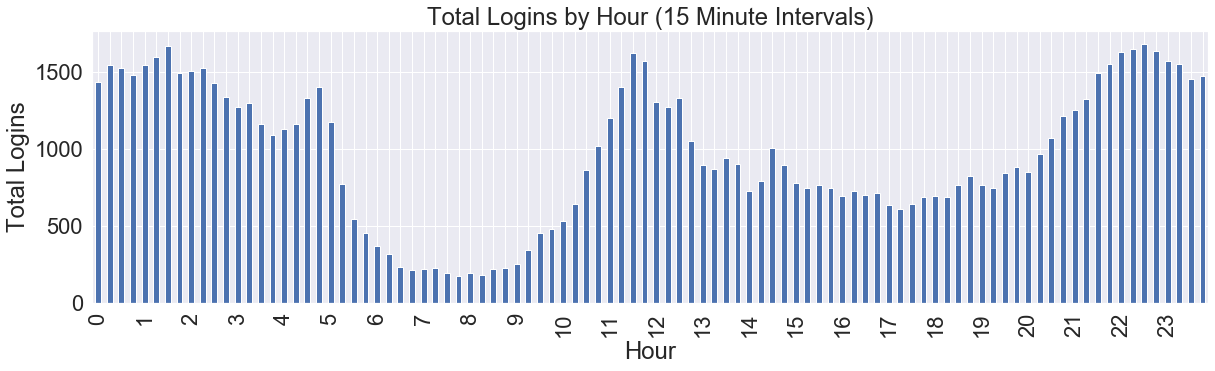

In [12]:
from matplotlib.ticker import FuncFormatter



logins_by_15 = logins_clean.groupby(["hour", "15_minute_interval"]).mean().rename({"minute": "logins"}, axis=1)["logins"].reset_index()

def format_tick(tick_val, tick_pos):
    if tick_val % 4 == 0:
        return int(logins_by_15.iloc[int(tick_val)]["hour"])


f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = logins_clean[["hour", "15_minute_interval", "total"]].groupby(["hour", "15_minute_interval"]).count().plot(kind="bar", ax=a, legend=False)
_ = a.xaxis.set_major_formatter(FuncFormatter(format_tick))
_ = plt.title("Total Logins by Hour (15 Minute Intervals)")
_ = plt.xlabel("Hour")
_ = plt.ylabel("Total Logins")


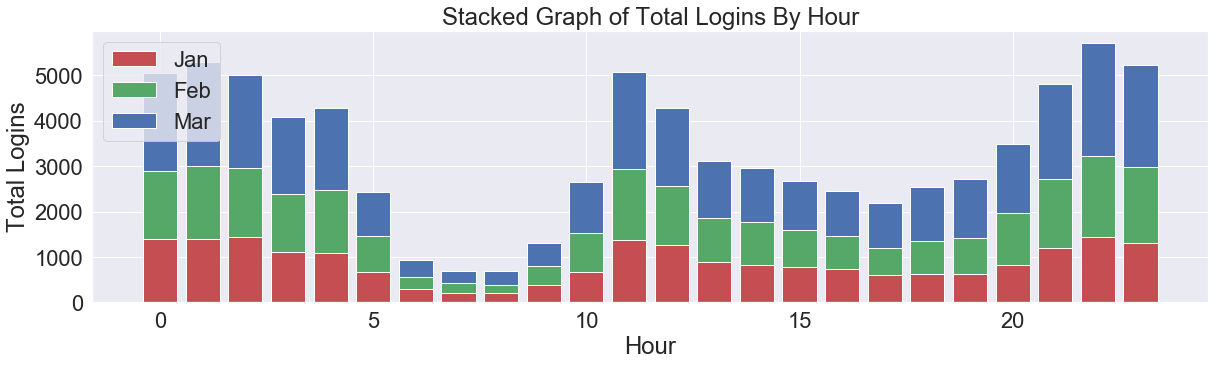

In [13]:
logins_jan = logins_clean[logins_clean.month == 1][["hour", "total"]].groupby("hour").count()
logins_feb = logins_clean[logins_clean.month == 2][["hour", "total"]].groupby("hour").count()
logins_mar = logins_clean[logins_clean.month == 3][["hour", "total"]].groupby("hour").count()

f, a = plt.subplots(1, 1, figsize=(20, 5))
jan = plt.bar(logins_jan.index, logins_jan["total"], color='r')
feb = plt.bar(logins_feb.index, logins_feb["total"], bottom=logins_jan["total"], color='g')
mar = plt.bar(logins_mar.index, logins_mar["total"], bottom=logins_jan["total"] + logins_feb["total"], color='b')
_ = plt.legend((jan[0], feb[0], mar[0]), ('Jan', 'Feb', 'Mar'), loc='upper left')
_ = plt.title("Stacked Graph of Total Logins By Hour")
_ = plt.xlabel("Hour")
_ = plt.ylabel("Total Logins")

# Login Behavior By Day of week

Login pattern for days of the week is roughly the same across all 3 months.

* Monday being the lowest number of logins 
* Logins increase throughout the week with Saturday being the busiest day
* In March, the login patter changes slightly in that generally logins drop on Sunday but we are seeing that Sundays had more logins than Saturdays for March

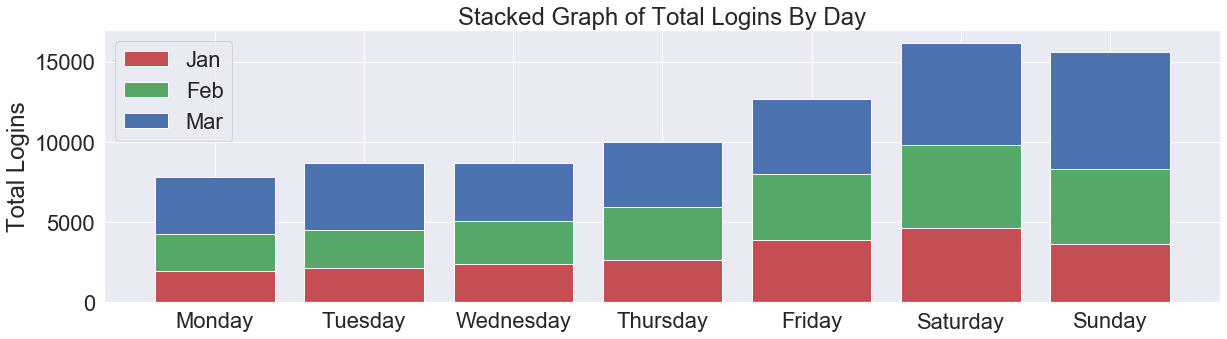

In [14]:
logins_dayofweek_jan = logins_clean[logins_clean.month == 1][["total", "dayofweek"]].groupby("dayofweek").count()
logins_dayofweek_feb = logins_clean[logins_clean.month == 2][["total", "dayofweek"]].groupby("dayofweek").count()
logins_dayofweek_mar = logins_clean[logins_clean.month == 3][["total", "dayofweek"]].groupby("dayofweek").count()


f, a = plt.subplots(1, 1, figsize=(20, 5))
jan = plt.bar(logins_dayofweek_jan.index, logins_dayofweek_jan.total, color='r')
feb = plt.bar(logins_dayofweek_feb.index, logins_dayofweek_feb.total, bottom = logins_dayofweek_jan.total, color='g')
mar = plt.bar(logins_dayofweek_mar.index, logins_dayofweek_mar.total, 
              bottom = logins_dayofweek_jan.total + logins_dayofweek_feb.total, color='b')
_ = a.set_xticklabels(["", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
_ = plt.legend((jan[0], feb[0], mar[0]), ('Jan', 'Feb', 'Mar'), loc='upper left')
_ = plt.title("Stacked Graph of Total Logins By Day")
_ = plt.ylabel("Total Logins")


# Login Behavior By Day

You see 7 days cycles for all 3 months - generally they follow the pattern described above.

However, if you look at March, there is a week (between 16th and 22nd) where you have higher login activity between Monday to Thursday than usual but not as many for Saturday and Sunday

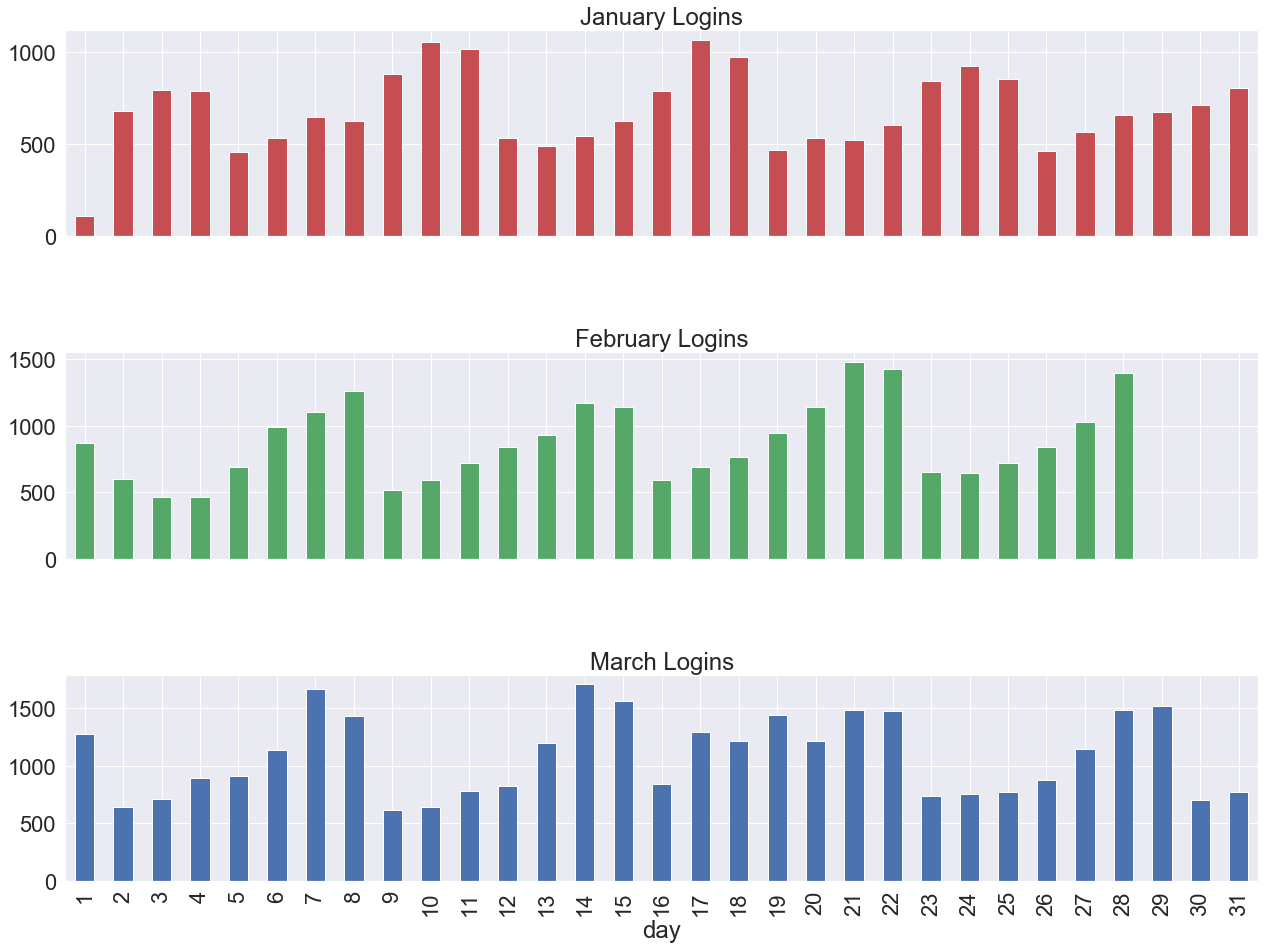

In [28]:
logins_day_jan = logins_clean[logins_clean.month == 1][["total", "day"]].groupby("day").count()
logins_day_feb = logins_clean[logins_clean.month == 2][["total", "day"]].groupby("day").count()
logins_day_mar = logins_clean[logins_clean.month == 3][["total", "day"]].groupby("day").count()


f, a = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
f.tight_layout(pad=4.0)


jan = logins_day_jan.plot(kind="bar", ax=a[0], label="Jan", color='r', legend=False)
_ = jan.set_title("January Logins")
feb = logins_day_feb.plot(kind="bar", ax=a[1], label="Feb", color='g', legend=False)
_ = feb.set_title("February Logins")
mar = logins_day_mar.plot(kind="bar", ax=a[2], label="Mar", color='b', legend=False)
_ = mar.set_title("March Logins")